# Run-and-Tumble

In this notebook, we will simulate the "run-and-tumble" model of bacterial chemotaxis, and see if it allows bacteria to move up the concentration gradient to find nutrients. The run-and-tumble model assumes that a bacterium swims by alternating between periods of straight motion ("run") and abrupt directional change ("tumble").

For simplicity, we will treat the bacterium as a point particle, and model the run as a spatial step in a chosen direction and the tumble as a random choice of a new direction for the next step. So far the description may sound just like a random walk (or Brownian motion). The special feature of chemotaxis is that the bacterium will sense the chemical concentration and modulate the tendency of tumbling. In particular, bacteria like _E. coli_ use *temporal* sensing, i.e., they check if the concentration has increased over time as they swim. If it does, then they will be less likely to tumble, which means they tend to run for a bit longer. Importantly, the run length does *not* depend on the absolute concentration at any given location, but on the history of concentration along its own path of swimming.

To model such behavior, let us assume that the running speed is constant, but the duration of the run depends on whether the concentration is increasing or not along the running trajectory. In the simulation, we will let the bacterium run for a default duration first, then check if the concentration has increased, and if so, we will let it run for some extra time proportional to how much the concentration has increased. Note that, in this implementation, each run will potentially have a different duration, so the simulation will not proceed in uniform time steps. In this case, it is necessary to keep track of the total time lapsed since the start of the simulation.

To simulate this run-and-tumble model, we will again define a Python class. Let us consider motion in 1D for simplicity. Since the bacterium is swimming in a chemical environment, we need as input the concentration profile as a function of spatial position.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class RunTumble1D:
    """
    simulate the run-and-tumble motion of a bacterium in 1D.
    """
    
    def __init__(self, dt=1., speed=1., x0=0.):
        """
        initialize the simulation by setting the initial position of the bacterium.
        inputs:
        dt: float, default time step size.
        speed: float, each time step the particle moves a distance dx=dt*speed.
        x0: float, initial position of the bacterium.
        """
        self.dt = dt    # default duration of run; actual time step will be modulated
        self.speed = speed    # speed of running, assumed to be constant
        self.t = 0.    # current time since the beginning of the simulation
        self.x = x0    # current position of the bacterium
    
    def run(self, T, concentration, alpha=1.):
        """
        run the simulation until time T (total time since the very beginning).
        inputs:
        T: float, total amount of time since the beginning of the simulation.
        concentration: function of spatial position, can be called as `c = concentration(x)`.
        alpha: float, proportionality constant such that (extra time) = (concentration increase) * alpha.
        """
        c_old = concentration(self.x)    # concentration at current position
        while self.t < T:    # run simulation until time `T`
            r = np.random.rand()    # draw a random number uniformly from between 0 and 1
            if r < 0.5:    # move left
                direction = -1    # direction of running
            else:    # move right
                direction = 1
            self.t = self.t + self.dt    # advance a default time step
            self.x = self.x + self.dt * self.speed * direction    # move a default distance in given direction
            c_new = concentration(self.x)    # concentration after moving a default distance
            if c_new > c_old:    # if concentration increased
                extra_t = (c_new - c_old) * alpha    # extra time for running
                self.t = self.t + extra_t    # add extra time
                self.x = self.x + extra_t * self.speed * direction    # move extra distance
                c_new = concentration(self.x)    # concentration after moving extra distance
            c_old = c_new    # update current concentration

Let us test this class by running the simulation in a constant gradient of chemical concentration. First we need to define a function to describe the concentration profile, which will be a linear function of position.

In [3]:
def const_grad(x):
    c = 1. * x    # constant gradient = 1.
    return c

Now let us run the simulation in this concentration profile.

In [4]:
rt1 = RunTumble1D()    # create an instance of simulation
rt1.run(1000, const_grad)    # notice how we passed a function as an argument
print(f'current position = {rt1.x}')

current position = 380.0


It looks like this bacterium managed to move up the gradient to a position with higher concentration. Note that one bacterium could have moved in the wrong direction just by chance. In order to see a general trend, we need to simulate a population of bacteria and look at their average behavior. For that, we can make $N$ simulations and look at the distribution of their positions after some time $T$.

In [5]:
N = 10000    # number of simulations to run
T = 1000    # number of time steps to run
results = []    # collect results from every simulation
for n in range(N):
    rt1 = RunTumble1D()
    rt1.run(T, const_grad)
    results.append(rt1.x)

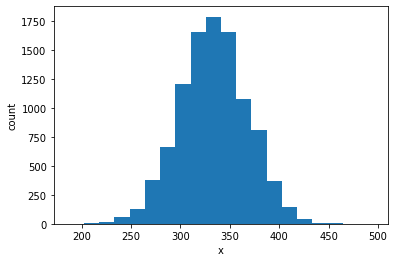

In [6]:
nbins = 20    # number of bins to use
plt.figure()
plt.hist(results, bins=nbins)
plt.xlabel('x')
plt.ylabel('count')
plt.show()

Bravo! The bacteria have indeed moved up the gradient, as their distribution has moved to the right of the origin.

We would like to see how the distribution changes over time. Because the distribution has a single peak, we can characterize it by its mean and variance, even though the distribution may not be exactly Gaussian. To see how the mean and variance change over time, we will run the simulation for different periods of time and collect the results at each time point.

You may have already noticed that our codes above are almost the same as for the [random walk](./random-walk.ipynb), except how we defined the simulation class (and that the `run` method for this class takes an extra argument). This is the advantage of using Python classes (a.k.a. object-oriented programming), which makes our codes rather modular and easy to reuse. In the following we will continue to use codes that are simply copied (and slightly modified) from the [random-walk](./random-walk.ipynb) example.

In [7]:
rt_list = [RunTumble1D() for n in range(N)]    # create and save N instances of the class
T_list = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]    # time points at which we check the distribution
xmean_list = [0]    # list to store the mean of the distribution at each time point above; first value is 0 at T=0
xvar_list = [0]    # list to store the variance of the distribution at each time point above; first value is 0 at T=0

for T in T_list[1:]:    # we will not check the first time point T=0
    results = []    # list to store results from every simulation
    for rt1 in rt_list:
        rt1.run(T, const_grad)    # run each simulation until time T
        results.append(rt1.x)
    xmean = np.mean(results)    # calculate the mean position at given time point
    xvar = np.var(results)    # calculate the variance at given time point
    xmean_list.append(xmean)
    xvar_list.append(xvar)

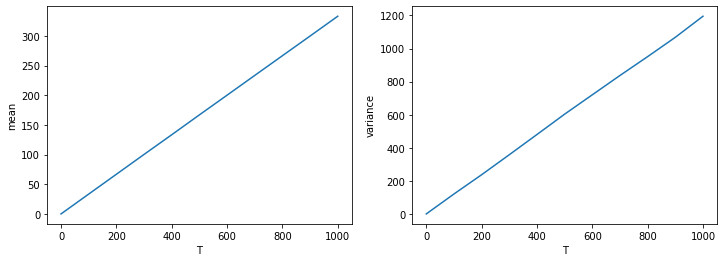

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(T_list, xmean_list)
ax[0].set_xlabel('T')
ax[0].set_ylabel('mean')
ax[1].plot(T_list, xvar_list)
ax[1].set_xlabel('T')
ax[1].set_ylabel('variance')
plt.show()

Notice how the variance increases linearly with time, just like for Brownian motion. This means that the process is effectively diffusive. Moreover, the mean of the distribution also increases linearly with time, which means that there is a drift. Therefore, the population of bacteria is on average moving to the right, that is, up the gradient! The drift velocity is proportional to the concentration gradient, and also depends on the parameter `alpha` in our model.

```{admonition} Exercise
:class: tip

How does the drift depend on `alpha`? Try to figure it out yourself by running simulations with different `alpha`s and plotting the drift versus `alpha`.
```

```{admonition} Solution
:class: note, dropdown

See below.
```

We will use a nested loop to repeat the above calculations for a set of different `alpha` values.

In [14]:
xmean_all = []    # list to store `xmean_list` for each `alpha` value
xvar_all = []    # list to store `xvar_list` for each `alpha` value
alpha_all = np.arange(0.3, 3.1, 0.3)    # range of `alpha` values to use

for alpha in alpha_all:
    print(f'running alpha = {alpha:.1f}', end='\r')
    rt_list = [RunTumble1D() for n in range(N)]    # create and save N instances of the class
    T_list = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]    # time points at which we check the distribution
    xmean_list = [0]    # list to store the mean of the distribution at each time point above; first value is 0 at T=0
    xvar_list = [0]    # list to store the variance of the distribution at each time point above; first value is 0 at T=0

    for T in T_list[1:]:    # we will not check the first time point T=0
        results = []    # list to store results from every simulation
        for rt1 in rt_list:
            rt1.run(T, const_grad, alpha=alpha)    # run using specific `alpha` value
            results.append(rt1.x)
        xmean = np.mean(results)    # calculate the mean position at given time point
        xvar = np.var(results)    # calculate the variance at given time point
        xmean_list.append(xmean)
        xvar_list.append(xvar)
    xmean_all.append(xmean_list)
    xvar_all.append(xvar_list)

We can plot the mean and variance curves for different `alpha`s on the same plots.

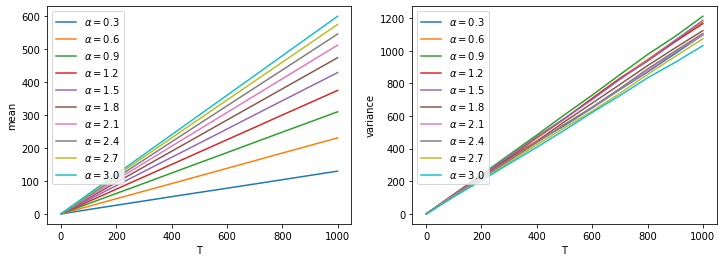

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
for i in range(len(alpha_all)):
    alpha = alpha_all[i]
    ax[0].plot(T_list, xmean_all[i], label=rf'$\alpha={alpha:.1f}$')
    ax[1].plot(T_list, xvar_all[i], label=rf'$\alpha={alpha:.1f}$')
ax[0].set_xlabel('T')
ax[0].set_ylabel('mean')
ax[0].legend(loc='upper left')
ax[1].set_xlabel('T')
ax[1].set_ylabel('variance')
ax[1].legend(loc='upper left')
plt.show()

Furthermore, we can plot the drift (slope of the mean curve) as a function of `alpha`.

In [18]:
drift_all = []
for i in range(len(alpha_all)):
    xmean_list = xmean_all[i]
    slope, intercept = np.polyfit(T_list, xmean_list, 1)
    drift_all.append(slope)

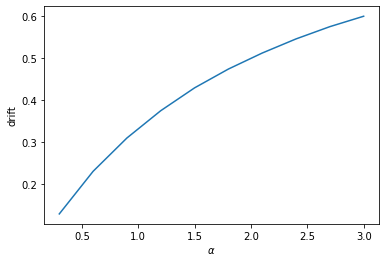

In [20]:
plt.figure()
plt.plot(alpha_all, drift_all)
plt.xlabel(r'$\alpha$')
plt.ylabel('drift')
plt.show()